In [26]:
import numpy as np

from type_definitions.test_case import TestCase
from type_definitions.test_result import TestResult
from type_definitions.utils import *
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [27]:
np.random.seed(99)

cases = generate_cases(40)
results = evaluate_cases(cases)
[(r.score, float(r.min_alt)) for r in results if not r.simulation_failed]

Error evaluating cases: velocity (3820.4841709011253) out of bounds
Error evaluating cases: alpha (-2.8212462835343413) out of bounds
Error evaluating cases: alpha (2.0215620532419125) out of bounds
Error evaluating cases: alpha (-25.82155313208543) out of bounds
Error evaluating cases: alpha (-2.8680569114910615) out of bounds
Error evaluating cases: alpha (3.129880467272257) out of bounds
Error evaluating cases: velocity (3019.244600993691) out of bounds
Error evaluating cases: alpha (2.301782691362485) out of bounds
Error evaluating cases: alpha (2.098526921266582) out of bounds
Error evaluating cases: velocity (159.1118565692932) out of bounds
Error evaluating cases: velocity (3363.2678617968395) out of bounds
Error evaluating cases: velocity (189.8173453803747) out of bounds
Error evaluating cases: alpha (-11.996171812304585) out of bounds
Error evaluating cases: alpha (2.206065305247585) out of bounds
Error evaluating cases: alpha (2.0432114476029755) out of bounds
Error evaluati

[(0.0, 2864.4223899408703),
 (-500.0, -7.826482751723926),
 (0.0, 2275.1527500557663),
 (0.0, 2752.248540992942),
 (0.0, 887.6628538606218),
 (0.04419635610840203, 2005.7021484850816),
 (0.0, 2296.525204303242),
 (0.0, 3673.1316928459546),
 (0.0, 2174.5907624524793),
 (0.0, 381.3241012539464),
 (0.0, 1956.924044599308),
 (-500.0, -349.9270494827896),
 (0.0, 2175.5361072495994)]

In [28]:
dbscan = DBSCAN(eps=4000, min_samples=2, metric="precomputed")
trajectories = [r.trajectory for r in results if not r.simulation_failed]
clusters = dbscan.fit_predict(pairwise_distances(trajectories))
unique_clusters = np.unique(clusters)

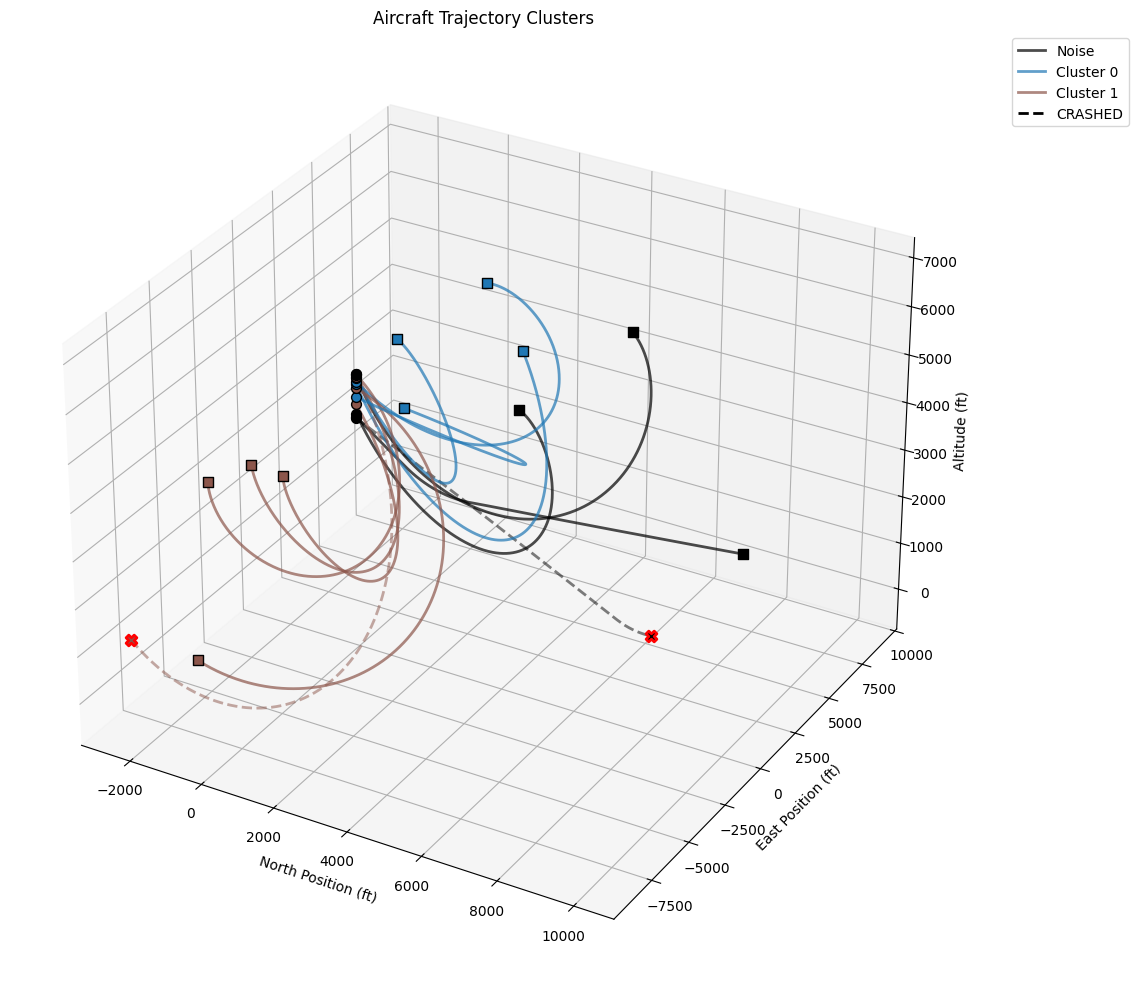

In [ ]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

valid_results = [r for r in results if not r.simulation_failed]

plotted_successful_clusters = set()
plotted_noise = False

for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:  # noise points in DBSCAN
        color = "black"
        if not result.crashed and not plotted_noise:
            label = "Outlier"
            plotted_noise = True
        else:
            label = None
    else:
        color = colors[cluster_id % len(colors)]
        if not result.crashed and cluster_id not in plotted_successful_clusters:
            label = f"Cluster {cluster_id}"
            plotted_successful_clusters.add(cluster_id)
        else:
            label = None

    if result.crashed:
        linestyle = "--"  # dashed line
        alpha = 0.5
    else:
        linestyle = "-"  # solid line
        alpha = 0.7

    ax.plot(
        traj[:, 0],
        traj[:, 1],
        traj[:, 2],
        color=color,
        alpha=alpha,
        linewidth=2,
        linestyle=linestyle,
        label=label,
    )

    # start point
    ax.scatter(
        traj[0, 0],
        traj[0, 1],
        traj[0, 2],
        color=color,
        s=50,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )
    # end points
    end_marker = "X" if result.crashed else "s"
    ax.scatter(
        traj[-1, 0],
        traj[-1, 1],
        traj[-1, 2],
        color=color,
        s=60 if result.crashed else 50,
        marker=end_marker,
        edgecolor="red" if result.crashed else "black",
        linewidth=2 if result.crashed else 1,
    )

if any(result.crashed for result in valid_results):
    ax.plot([], [], color="black", linestyle="--", linewidth=2, label="CRASHED")

ax.set_xlabel("North Position (ft)")
ax.set_ylabel("East Position (ft)")
ax.set_zlabel("Altitude (ft)")
ax.set_title("Aircraft Trajectory Clusters")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()